$\newcommand{\mb}[1]{\mathbf{ #1 }}$
$\newcommand{\bb}[1]{\mathbb{ #1 }}$
$\newcommand{\bs}[1]{\boldsymbol{ #1 }}$
$\newcommand{\R}{\bb{R}}$
$\newcommand{\abs}[1]{\left\vert #1 \right\vert}$
$\newcommand{\nrm}[1]{\left\Vert #1 \right\Vert}$
$\newcommand{\ip}[2]{\left\langle #1, #2 \right\rangle}$

In [1]:
from matplotlib.pyplot import figure, grid, legend, plot, show, title, xlabel, ylabel
from numpy import array, concatenate, diag, dot, identity, linspace, ones, outer, zeros
from numpy.linalg import eig, norm, solve
from numpy.random import rand, randn
from scipy.linalg import block_diag

from main import AffineQuadCLF, differentiate, LinearSystemDynamics, LQRController, lqr_cost, RandomController, rand_orthogonal

First, we will generate a random single-input single-output (SISO) system of the form:

\begin{equation}
    \dot{\mb{x}} = \mb{A}\mb{x} + \mb{b}u,
\end{equation}

with state $\mb{x} \in \R^n$, action $u \in \R$, and matrix $\mb{A} \in \R^{n \times n}$ and vector $\mb{b} \in \R^n$ in controllable canonical form:

\begin{align}
    \mb{A} &= \begin{bmatrix}
        0 & 1 & & &\\
        & 0 & 1 & &\\
        & & \ddots & \ddots &\\
        & & & 0 & 1\\
        -a_{n - 1} & -a_{n - 2} & -a_{n - 3} & \cdots & -a_0
    \end{bmatrix},\\
    \mb{b} &= \begin{bmatrix}
        0\\
        \vdots\\
        0\\
        1
    \end{bmatrix},
\end{align}
where $\mb{a} = (a_0, \cdots, a_{n - 1})$ is a random vector. Let $\mb{Q} \in \R^{n \times n}$ be a random orthogonal matrix, and let $\mb{y} = \mb{Q}\mb{x}$. Then the system can be equivalently expressed as:

\begin{equation}
    \dot{\mb{x}} = \mb{Q}^\top\dot{\mb{y}} = \mb{A}\mb{Q}^\top\mb{y} + \mb{b}u = \mb{A}\mb{x} + \mb{b}u,
\end{equation}

or:

\begin{equation}
    \dot{\mb{y}} = \mb{Q}\mb{A}\mb{Q}^\top\mb{y} + \mb{Q}\mb{b}u,
\end{equation}

Next, we will generate a random SISO system of the form:

\begin{equation}
    \dot{\widehat{\mb{y}}} = \mb{Q}\widehat{\mb{A}}\mb{Q}^\top\mb{y} + \mb{Q}\widehat{\mb{b}}u,
\end{equation}

where $\widehat{\mb{A}} = \mb{A} - \mb{b} \bs{\epsilon}^\top$ and $\widehat{\mb{b}} = \mb{b} - \mb{b} \epsilon$. Here, $\bs{\epsilon} \in \R^n$ is a random vector and $\epsilon$ is a random variable, scaled such that $\nrm{\bs{\epsilon}}_2 \leq M_\mb{A}$ and $\abs{\epsilon} \leq M_{\mb{b}}$ for known upper bounds $M_\mb{A}, M_{\mb{b}} \geq 0$. Then:

\begin{align}
    \nrm{\mb{Q}\mb{A}\mb{Q}^\top - \mb{Q}\widehat{\mb{A}}\mb{Q}^\top}_2 &= \nrm{\mb{A} - \widehat{\mb{A}}}_2\\
    &= \nrm{\mb{b}\bs{\epsilon}^\top}_2\\
    &= \nrm{\mb{b}}_2\nrm{\bs{\epsilon}}_2\\
    &\leq M_{\mb{A}},
\end{align}

and:

\begin{align}
    \nrm{\mb{Q}\mb{b} - \mb{Q}\widehat{\mb{b}}}_2 &= \nrm{\mb{b} - \widehat{\mb{b}}}_2\\
    &= \nrm{\mb{b} \epsilon}_2\\
    &= \abs{\epsilon} \nrm{\mb{b}}\\
    &\leq M_{\mb{b}}.
\end{align}

Now, consider $m$ SISO systems generated this way, represented as the block diagonal system:

\begin{align}
    \dot{\mb{Y}} = \underbrace{\begin{bmatrix} \mb{Q}_1\mb{A}_1\mb{Q}^\top & & \\ & \ddots & \\ & & \mb{Q}_m\mb{A}_m\mb{Q}_m^\top \end{bmatrix}}_{\mb{A}} \mb{Y} + \underbrace{\begin{bmatrix} \mb{Q}_1\mb{B}_1 & & \\ & \ddots & \\ & & \mb{Q}_m\mb{B}_m \end{bmatrix}}_{\mb{B}} \mb{u},
\end{align}

where $\mb{Y} = (\mb{x}_1, \dots, \mb{x}_m) \in \R^{n_1} \times \cdots \times \R^{n_m}$, and $\mb{u} = (u_1, \dots, u_m) \in \R^m$. Similarly, consider the estimated block diagonal system:

\begin{align}
    \dot{\widehat{\mb{Y}}} = \underbrace{\begin{bmatrix} \mb{Q}_1\widehat{\mb{A}}_1\mb{Q}^\top & & \\ & \ddots & \\ & & \mb{Q}_m\widehat{\mb{A}}_m\mb{Q}_m^\top \end{bmatrix}}_{\widehat{\mb{A}}} \widehat{\mb{Y}} + \underbrace{\begin{bmatrix} \mb{Q}_1\widehat{\mb{B}}_1 & & \\ & \ddots & \\ & & \mb{Q}_m\widehat{\mb{B}}_m \end{bmatrix}}_{\widehat{\mb{B}}} \mb{u}.
\end{align}

Let $n = n_1 + \cdots + n_m$, and let $\mb{Q} \in \R^{n \times n}$ be orthogonal, and let $\mb{Z} = \mb{Q}\mb{Y}$ and $\widehat{\mb{Z}} = \mb{Q}\widehat{\mb{Y}}$. Then $\mb{Z} = \mb{Q}\mb{A}\mb{Q}^\top\mb{Z} + \mb{Q}\mb{B}\mb{u}$ and $\widehat{\mb{Z}} = \mb{Q}\widehat{\mb{A}}\mb{Q}^\top\widehat{\mb{Z}} + \mb{Q}\widehat{\mb{B}}\mb{u}$, with $\nrm{ \mb{Q}\mb{A}\mb{Q}^\top - \mb{Q}\widehat{\mb{A}}\mb{Q}^\top}_2 = \nrm{\mb{A} - \widehat{\mb{A}}}_2$ and $\nrm{ \mb{Q}\mb{B} - \mb{Q}\widehat{\mb{B}}}_2 = \nrm{\mb{B} - \widehat{\mb{B}}}_2$. Since:

\begin{align}
    \nrm{\mb{A} - \widehat{\mb{A}}}^2_2 &= \sup_{\substack{\mb{v} \in \R^n \\ \nrm{\mb{v}}_2 = 1}} \nrm{(\mb{A} - \widehat{\mb{A}})\mb{v}}^2_2\\
    &= \sup_{\substack{\mb{v}_1 \in \R^{n_1} \\ \vdots \\ \mb{v}_m \in \R^{n_m} \\ \nrm{\mb{v}_1}_2^2 + \nrm{\mb{v}_m}_2^2 = 1}} \nrm{\mb{A}_1\mb{v}_1}_2^2 + \cdots + \nrm{\mb{A}_m\mb{v}_m}_2^2\\
    &= \sup_{\substack{c_1, \dots, c_m \in \R \\ c_1^2 + \dots + c_m^2 = 1}} c_1^2\nrm{\mb{A}_1}_2^2 + \cdots + c_m^2 \nrm{\mb{A}_m}_2^2\\
    &= \max{\{ \nrm{\mb{A}_1}^2_2, \dots, \nrm{\mb{A}_m}^2_2 \}}\\
    &\leq M_{\mb{A}}^2,
\end{align}

we have $\nrm{ \mb{Q}\mb{A}\mb{Q}^\top - \mb{Q}\widehat{\mb{A}}\mb{Q}^\top}_2 \leq M_{\mb{A}}$ and similarly, $\nrm{ \mb{Q}\mb{B} - \mb{Q}\widehat{\mb{B}}}_2 \leq M_{\mb{b}}$. 

We will build such a system from $5$ SISO systems, each with $4$ states, and upper bounds $M_{\mb{A}} = M_{\mb{b}} = 0.2$.

In [2]:
def siso(n, bound_A, bound_B):
    A = diag(ones(n - 1), 1)
    A[-1] = randn(n) 
    
    B = zeros((n, 1))
    B[-1] = 1
    
    A_pert = randn(1, n)
    A_pert = A_pert * (bound_A * rand()) / norm(A_pert)
    A_hat = A + concatenate([zeros((n - 1, n)), A_pert])
    
    B_pert = randn(1, 1)
    B_pert = B_pert * (bound_B * rand()) / norm(B_pert)
    B_hat = B + concatenate([zeros((n - 1, 1)), B_pert])
    
    Q = rand_orthogonal(n)
    A = dot(Q, dot(A, Q.T))
    A_hat = dot(Q, dot(A_hat, Q.T))
    B = dot(Q, B)
    B_hat = dot(Q, B_hat)
    
    return A, B, A_hat, B_hat

n, m = 20, 5
k = n // m
bound_A, bound_B = 0.2, 0.2

sisos = (siso(k, bound_A, bound_B) for _ in range(m))
As, Bs, A_hats, B_hats = zip(*sisos)
A = block_diag(*As)
A_hat = block_diag(*A_hats)
B = block_diag(*Bs)
B_hat = block_diag(*B_hats)

Q = rand_orthogonal(n)
A = dot(Q, dot(A, Q.T))
A_hat = dot(Q, dot(A_hat, Q.T))
B = dot(Q, B)
B_hat = dot(Q, B_hat)

system_true = LinearSystemDynamics(A, B)
system_est = LinearSystemDynamics(A_hat, B_hat)

From this point forward, we will refer to the actual system as:

\begin{equation}
    \dot{\mb{x}} = \mb{A}\mb{x} + \mb{B}\mb{u},
\end{equation}

with state $\mb{x} \in \R^n$, action $\mb{u} \in \R^m$, and $(\mb{A}, \mb{B}) \in \R^{n \times n} \times \R^{n \times m}$ controllable, and the estimated system as:

\begin{equation}
    \dot{\widehat{\mb{x}}} = \widehat{\mb{A}}\widehat{\mb{x}} + \widehat{\mb{B}}\mb{u},
\end{equation}

with estimated state $\widehat{\mb{x}} \in \R^n$ and $(\widehat{\mb{A}}, \widehat{\mb{B}}) \in \R^{n \times n} \times \R^{n \times m}$ controllable. We can represent the actual system in terms of the estimated system as:

\begin{equation}
    \dot{\mb{x}} = \widehat{\mb{A}}\mb{x} + \widehat{\mb{B}}\mb{u} + (\mb{A} - \widehat{\mb{A}})\mb{x} + (\mb{B} - \widehat{\mb{B}})\mb{u}.
\end{equation}

Let $\mb{Q} \in \bb{S}^n_{++}$ and $\mb{R} \in \bb{S}^m_{++}$. For initial state $\mb{x}_0 \in \R^n$, consider the infinite-horizon linear quadratic regulator (LQR) optimization problems:

\begin{align}
    J(\mb{x}_0) = \inf_{\substack{ \mb{x} \in (\mathcal{L}^2 \cap C^1) (\R_+; \R^n) \\ \mb{u} \in \mathcal{L}^2(\R_+; \R^m) }} ~&~ \int_{0}^\infty \left( \mb{x}(t)^\top\mb{Q}\mb{x}(t) + \mb{u}(t)^\top\mb{R}\mb{u}(t) \right) \mathrm{d}t\\
    \mathrm{s.t.} ~&~ \mb{x}(0) = \mb{x}_0\\
    &~ \dot{\mb{x}}(t) = \mb{A}\mb{x}(t) + \mb{B}\mb{u}(t) ~\mathrm{for}~ t > 0,
\end{align}

and:

\begin{align}
    \widehat{J}(\mb{x}_0) = \inf_{\substack{ \widehat{\mb{x}} \in (\mathcal{L}^2 \cap C^1) (\R_+; \R^n) \\ \widehat{\mb{u}} \in \mathcal{L}^2(\R_+; \R^m) }} ~&~ \int_{0}^\infty \left( \widehat{\mb{x}}(t)^\top\mb{Q}\widehat{\mb{x}}(t) + \widehat{\mb{u}}(t)^\top\mb{R}\widehat{\mb{u}}(t) \right) \mathrm{d}t\\
    \mathrm{s.t.} ~&~ \widehat{\mb{x}}(0) = \mb{x}_0\\
    &~ \dot{\widehat{\mb{x}}}(t) = \widehat{\mb{A}}\widehat{\mb{x}}(t) + \widehat{\mb{B}}\widehat{\mb{u}}(t) ~\mathrm{for}~ t > 0.
\end{align}

Since $(\mb{A}, \mb{B})$ and $(\widehat{\mb{A}}, \widehat{\mb{B}})$ are controllable, there exist $\mb{P}, \widehat{\mb{P}} \in \bb{S}^n_{++}$ satisfying the continuous-time algebraic Riccati equations (CARE) $\mb{A}^\top\mb{P} + \mb{P}\mb{A} - \mb{P}\mb{B}\mb{R}^{-1}\mb{B}^\top\mb{P} = -\mb{Q}$ and $\widehat{\mb{A}}^\top\widehat{\mb{P}} + \widehat{\mb{P}}\widehat{\mb{A}} - \widehat{\mb{P}}\widehat{\mb{B}}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}} = -\mb{Q}$. The solutions to the LQR optimization problems satisfy $\mb{u}(t) = -\frac{1}{2}\mb{R}^{-1}\mb{B}^\top\mb{P}\mb{x}(t)$ and $\widehat{\mb{u}}(t) = -\frac{1}{2}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}\widehat{\mb{x}}(t)$, respectively, for $t > 0$. Additionally, $V, \widehat{V}: \R^n \to \R_+$ defined as $V(\mb{x}) = \mb{x}^\top\mb{P}\mb{x}$ and $\widehat{V}(\mb{x}) = \mb{x}^\top\widehat{\mb{P}}\mb{x}$ for all states $\mb{x} \in \R^n$ are control Lyapunov functions (CLFs) for the true and estimated systems, respectively.

In [3]:
Q = identity(n)
R = identity(m)

lyap_est = AffineQuadCLF.build_care(system_est, Q, R)
lyap_true = AffineQuadCLF.build_care(system_true, Q, R)

lqr_est = LQRController.build(system_est, Q, R)
lqr_true = LQRController.build(system_true, Q, R)

Now, we apply the LQR controller solving the estimated problem to the true system. That is, we simulate the system:

\begin{equation}
    \dot{\mb{x}} = \left(\mb{A} - \frac{1}{2}\mb{B}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}} \right)\mb{x},
\end{equation}

from a random initial condition $\mb{x}_0$. We simulate the system for $20$ seconds, with sampled control at a sample frequency of $100$ Hz. We compare the performance to that of an oracle, applying the LQR controller solving the true problem to the true system.

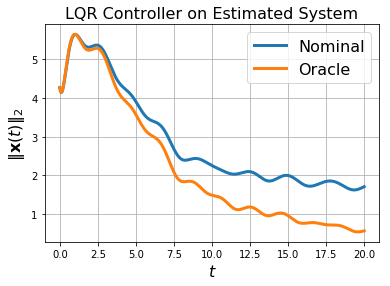

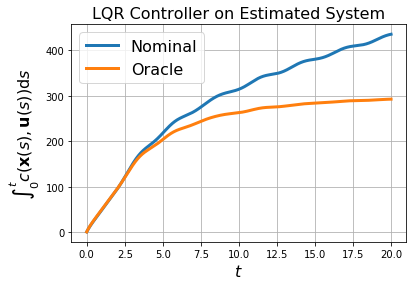

In [4]:
x_0 = randn(n)
T = 20
N = 100
ts = linspace(0, T, T * N)

xs, us = system_true.simulate(x_0, lqr_est, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_est = (xs, lqr_costs)

xs, us = system_true.simulate(x_0, lqr_true, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_true = (xs, lqr_costs)

figure()
xs, _ = data_est
plot(ts, norm(xs, axis=1), linewidth=3, label='Nominal')
xs, _ = data_true
plot(ts, norm(xs, axis=1), linewidth=3, label='Oracle')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\Vert \mathbf{x}(t) \Vert_2$', fontsize=16)
title('LQR Controller on Estimated System', fontsize=16)
show()

figure()
_, lqr_costs = data_est
plot(ts[:-1], lqr_costs, linewidth=3, label='Nominal')
_, lqr_costs = data_true
plot(ts[:-1], lqr_costs, linewidth=3, label='Oracle')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
title('LQR Controller on Estimated System', fontsize=16)
show()

Clearly, the oracle controller outperforms the LQR controller solving the estimated problem. However, we can simulate the system with a random controller distributed as follows:

\begin{equation}
    \mb{u}(\mb{x}) \sim \mathcal{N}\left( -\frac{1}{2}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}\mb{x}, \bs{\Sigma} \right),
\end{equation}

with covariance matrix $\bs{\Sigma} \in \bb{S}^m_{++}$, and gather state and action data to better fit models relevant to controlling the system. We simulate the system under the same conditions with this controller, using $\bs{\Sigma} = (0.1)^2 \cdot \mb{I}_m$.

Since we may be interested in fitting a better model of the dynamics, we sample random normal perturbations at a frequency of $5$ Hz. By restricting the frequency of perturbations, we ensure that the additional high-frequency dynamics aliased by a differentiation filter will be negligible.

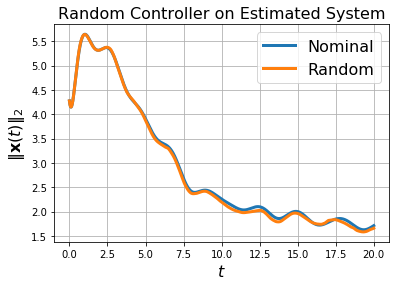

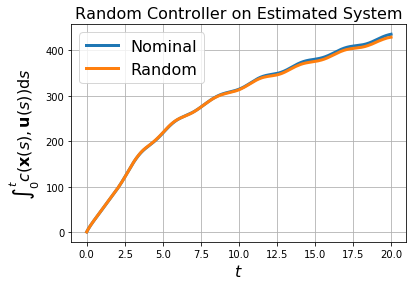

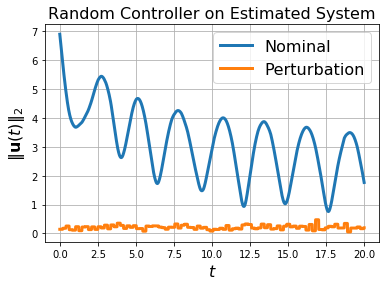

In [5]:
cov = (0.1 ** 2) * identity(m)
reps = 20
lqr_rand = RandomController(lqr_est, cov, reps)

xs, us = system_true.simulate(x_0, lqr_rand, ts)
us = array([array([u_nom, u_pert, lqr_rand.process((u_nom, u_pert))]) for u_nom, u_pert in us])
lqr_costs = lqr_cost(Q, R, xs, us[:, -1], ts)
data_rand = (xs, lqr_costs)

figure()
xs, _ = data_est
plot(ts, norm(xs, axis=1), linewidth=3, label='Nominal')
xs, _ = data_rand
plot(ts, norm(xs, axis=1), linewidth=3, label='Random')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\Vert \mathbf{x}(t) \Vert_2$', fontsize=16)
title('Random Controller on Estimated System', fontsize=16)
show()

figure()
_, lqr_costs = data_est
plot(ts[:-1], lqr_costs, linewidth=3, label='Nominal')
_, lqr_costs = data_rand
plot(ts[:-1], lqr_costs, linewidth=3, label='Random')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
title('Random Controller on Estimated System', fontsize=16)

figure()
plot(ts[:-1], norm(us[:, 0], axis=1), linewidth=3, label='Nominal')
plot(ts[:-1], norm(us[:, 1], axis=1), linewidth=3, label='Perturbation')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\Vert \mathbf{u}(t) \Vert_2$', fontsize=16)
title('Random Controller on Estimated System', fontsize=16)
show()

We can numerically differentiate the resulting state trajectory using a centered differentiation filter with window size $3$.

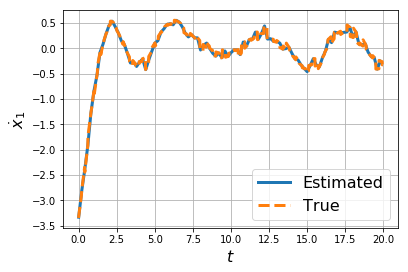

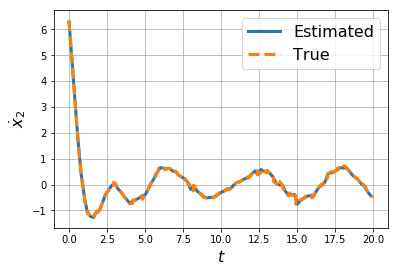

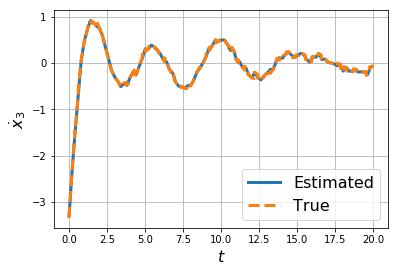

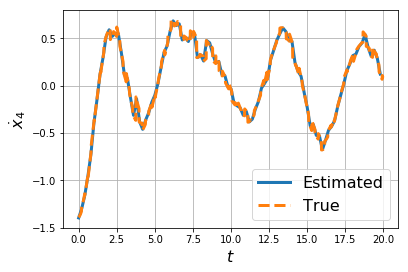

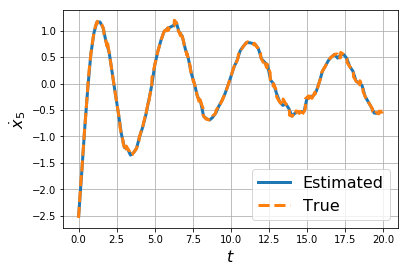

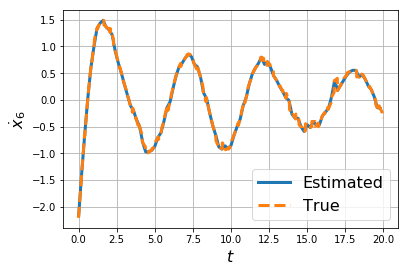

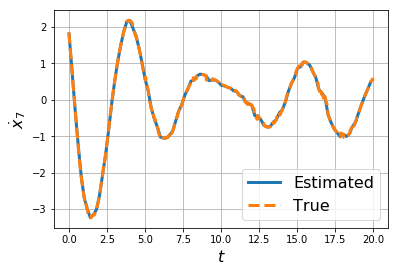

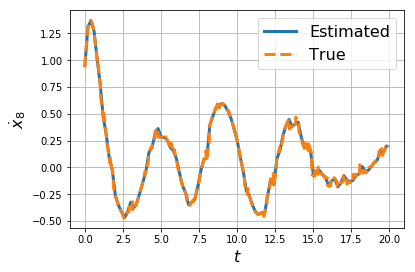

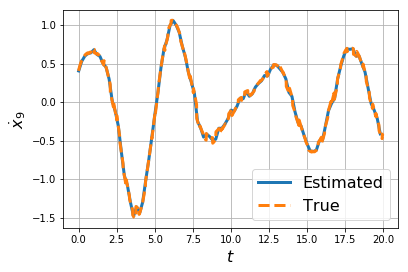

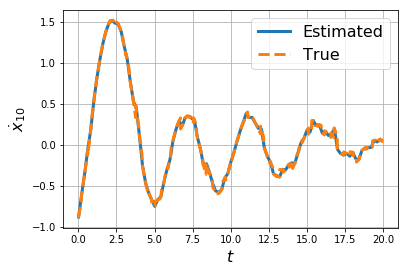

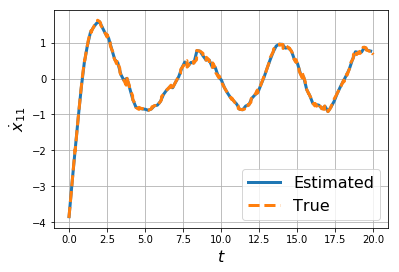

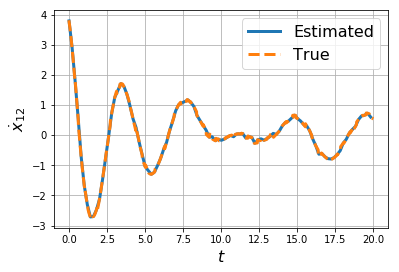

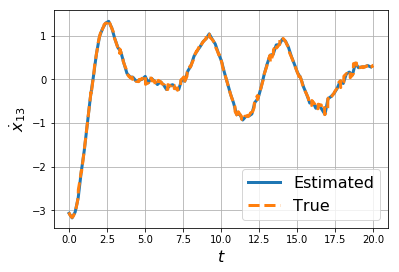

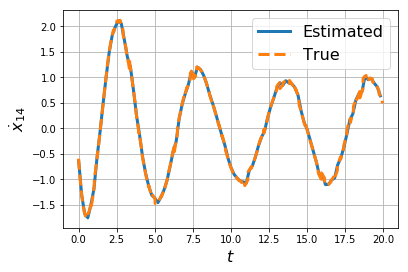

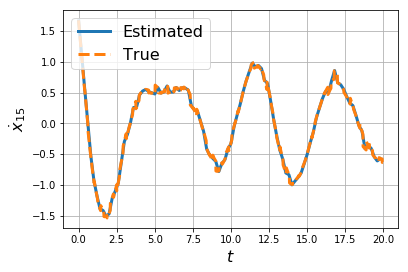

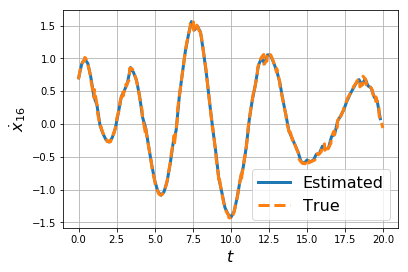

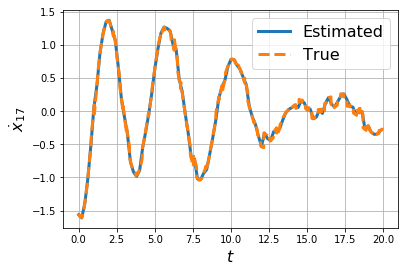

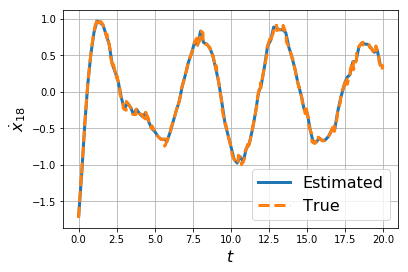

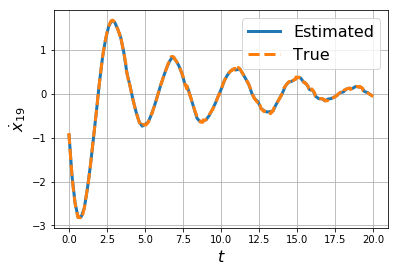

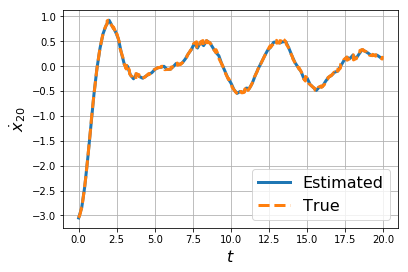

In [6]:
xs = xs[:-1]
us = us[:, -1]
ts = ts[:-1]

x_dots = array([system_true.eval_dot(x, u, t) for x, u, t in zip(xs, us, ts)])
data_compare = (ts, x_dots)

window = 3
half_window = (window - 1) // 2

x_dots = differentiate(xs, ts)[::reps]
xs = xs[half_window:-half_window:reps]
us = us[half_window:-half_window:reps]
ts = ts[half_window:-half_window:reps]
data = (xs, us, ts, x_dots)

axs = [figure().add_subplot(111) for _ in range(n)]
for i, ax in enumerate(axs):
    _, _, ts, x_dots = data
    ax.plot(ts, x_dots[:, i], linewidth=3, label='Estimated')
    ts, x_dots = data_compare
    ax.plot(ts, x_dots[:, i], '--', linewidth=3, label='True')
    ax.grid()
    ax.legend(fontsize=16)
    ax.set_xlabel('$t$', fontsize=16)
    ax.set_ylabel('$\dot{x}_{' + str(i + 1) + '}$', fontsize=16)
    
show()

We now have a dataset of the form $D = \{ ((\mb{x}_i, \mb{u}_i), \dot{\mb{x}}_i) \}_{i=1}^N$, where each label $\dot{\mb{x}}_i$ is approximate due to numerical differentiation error. Consider the ordinary least-squares optimization problem:

\begin{align}
    \widehat{\mathcal{L}}(D) &= \inf_{\substack{ \widehat{\mb{A}} \in \R^{n \times n} \\ \widehat{\mb{B}} \in \R^{n \times m} }} \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \nrm{\dot{\mb{x}}_i - (\widehat{\mb{A}}\mb{x}_i + \widehat{\mb{B}}\mb{u}_i) }_2^2\\ 
    &= \inf_{\widehat{\mb{W}} \in \R^{n \times (n + m)}} \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \nrm{\dot{\mb{x}}_i - \widehat{\mb{W}} \mb{z}_i}_2^2,
\end{align}

where $\widehat{\mb{W}} = (\widehat{\mb{A}}, \widehat{\mb{B}})$ and $\mb{z}_i = (\mb{x}_i, \mb{u}_i)$ for $i = 1, \dots, N$. This can be equivalently expressed as:

\begin{align}
    \widehat{\mathcal{L}}(D) &= \inf_{\widehat{\mb{W}} \in \R^{n \times (n + m)}} \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left( \nrm{\dot{\mb{x}}_i}_2^2 - 2 \dot{\mb{x}}_i^\top\widehat{\mb{W}}\mb{z}_i + \mb{z}_i^\top\widehat{\mb{W}}^\top\widehat{\mb{W}}\mb{z}_i \right)\\ 
    &= \inf_{\widehat{\mb{W}} \in \R^{n \times (n + m)}} \underbrace{\frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left( \nrm{\dot{\mb{x}}_i}_2^2 -2 \ip{\dot{\mb{x}}_i\mb{z}_i^\top}{\widehat{\mb{W}}}_F + \ip{\widehat{\mb{W}}\mb{z}_i\mb{z}_i^\top}{\widehat{\mb{W}}}_F \right)}_{\cal{L}(\widehat{\mb{W}})},
\end{align}

where $\ip{\mb{X}}{\mb{Y}}_F = \mathrm{tr}~\mb{X}^\top\mb{Y}$ denotes the trace inner product for $\mb{X}, \mb{Y} \in \R^{n \times (n + m)}$, inducing the Frobenius norm. Here, $\cal{L}: \R^{n \times (n + m)} \to \R_+$ denotes the Lagrangian associated with this problem, and the optimal solution satisfies:

\begin{align}
    \nabla \mathcal{L}(\widehat{\mb{W}}^*) &= \frac{1}{N} \sum_{i=1}^N \left( \widehat{\mb{W}}\mb{z}_i\mb{z}_i^\top - \dot{\mb{x}}_i\mb{z}_i^\top \right)\\
    &= \frac{1}{N} \left( \widehat{\mb{W}} \left( \sum_{i=1}^N \mb{z}_i\mb{z}_i^\top \right) - \sum_{i=1}^N \dot{\mb{x}}_i\mb{z}_i^\top \right)\\
    &= \mb{0}_{n \times (n + m)}.
\end{align}

Therefore, the optimal estimates $\widehat{\mb{A}}$ and $\widehat{\mb{B}}$ are:

\begin{equation}
    \begin{bmatrix} \widehat{\mb{A}}^* & \widehat{\mb{B}}^* \end{bmatrix} = \left( \sum_{i=1}^N \dot{\mb{x}}_i \begin{bmatrix} \mb{x}_i \\ \mb{u}_i \end{bmatrix}^\top \right) \left( \sum_{i=1}^N \begin{bmatrix} \mb{x}_i \\ \mb{u}_i \end{bmatrix} \begin{bmatrix} \mb{x}_i \\ \mb{u}_i \end{bmatrix}^\top \right)^{-1}.
\end{equation}

The associated regularized least-squares problem is:

\begin{equation}
    \inf_{\widehat{\mb{W}} \in \R^{n \times (n + m)}} \frac{1}{N} \sum_{i=1}^N \frac{1}{2} \left( \nrm{\dot{\mb{x}}_i}_2^2 -2 \ip{\dot{\mb{x}}_i\mb{z}_i^\top}{\widehat{\mb{W}}}_F + \ip{\widehat{\mb{W}}\mb{z}_i\mb{z}_i^\top}{\widehat{\mb{W}}}_F \right) + \frac{1}{2N}\lambda \nrm{\widehat{\mb{W}}}_F^2,
\end{equation}

for coefficient $\lambda \geq 0$. The associated optimal estimates are:

\begin{equation}
    \begin{bmatrix} \widehat{\mb{A}}^* & \widehat{\mb{B}}^* \end{bmatrix} = \left( \sum_{i=1}^N \dot{\mb{x}}_i \begin{bmatrix} \mb{x}_i \\ \mb{u}_i \end{bmatrix}^\top \right) \left( \sum_{i=1}^N \begin{bmatrix} \mb{x}_i \\ \mb{u}_i \end{bmatrix} \begin{bmatrix} \mb{x}_i \\ \mb{u}_i \end{bmatrix}^\top + \lambda \mb{I}_{(n + m) \times (n + m)} \right)^{-1}.
\end{equation}

We solve this optimization problem using $\lambda = 0.1$.

In [7]:
xs, us, _, x_dots = data
concat = lambda x, u: concatenate([x, u])

def least_squares(xs, us, x_dots, reg=0):
    _, n = xs.shape
    _, m = us.shape
    M = sum([outer(concat(x, u), concat(x, u)) for x, u in zip(xs, us)]) + reg * identity(n + m)
    Y = sum([outer(x_dot, concat(x, u)) for x, u, x_dot in zip(xs, us, x_dots)])
    W = solve(M, Y.T).T
    A_learned = W[:, :n]
    B_learned = W[:, n:]
    return A_learned, B_learned

reg = 0.01
A_learned, B_learned = least_squares(xs, us, x_dots, reg)

We can improve the quality of the estimates by simulating the system multiple times. We simulate the system $20$ times and solve the estimation problem after each experiment. 

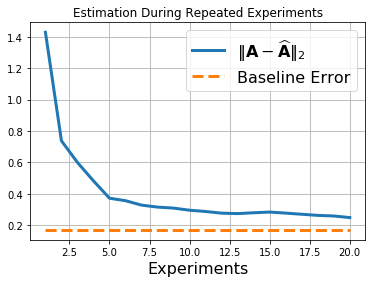

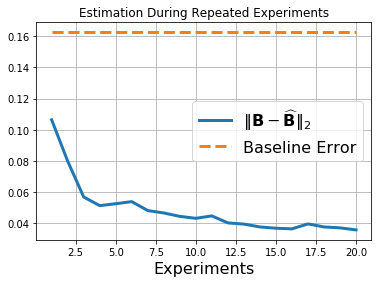

In [8]:
def experiment(system, x_0, controller, ts, window=3, reps=2):
    xs, us = system.simulate(x_0, controller, ts)
    
    xs = xs[:-1]
    us = array([controller.process(u) for u in us])
    ts = ts[:-1]
    
    half_window = (window - 1) // 2

    x_dots = differentiate(xs, ts)[::reps]
    xs = xs[half_window:-half_window:reps]
    us = us[half_window:-half_window:reps]
        
    return xs, us, x_dots

K = 20
data = [experiment(system_true, x_0, lqr_rand, ts, window, reps) for _ in range(K)]
xs, us, x_dots = zip(*data)
xs = array(xs)
us = array(us)
x_dots = array(x_dots)

ests = [least_squares(concatenate(xs[:k]), concatenate(us[:k]), concatenate(x_dots[:k]), reg) for k in range(1, K + 1)]
errs = [(norm(A - A_hat, 2), norm(B - B_hat, 2)) for A_hat, B_hat in ests]
A_errs, B_errs = zip(*errs)

figure()
plot(range(1, K + 1), A_errs, linewidth=3, label='$\Vert \mathbf{A} - \widehat{\mathbf{A}} \Vert_2$')
plot(range(1, K + 1), norm(A - A_hat, 2) * ones(K), '--', linewidth=3, label='Baseline Error')
grid()
legend(fontsize=16)
xlabel('Experiments', fontsize=16)
title('Estimation During Repeated Experiments')

figure()
plot(range(1, K + 1), B_errs, linewidth=3, label='$\Vert \mathbf{B} - \widehat{\mathbf{B}} \Vert_2$')
plot(range(1, K + 1), norm(B - B_hat, 2) * ones(K), '--', linewidth=3, label='Baseline Error')
grid()
legend(fontsize=16)
xlabel('Experiments', fontsize=16)
title('Estimation During Repeated Experiments')

show()

We can use the final estimates $\widehat{\mb{A}}$ and $\widehat{\mb{B}}$ to design an improved controller.

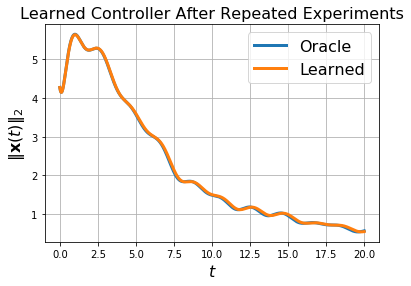

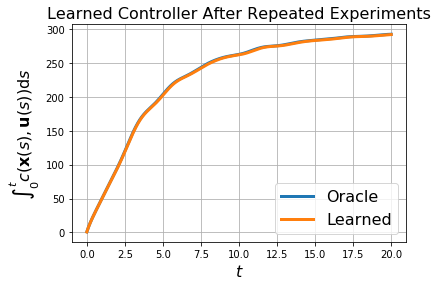

In [9]:
A_learned, B_learned = ests[-1]

system_learned = LinearSystemDynamics(A_learned, B_learned)
lyap_learned = AffineQuadCLF.build_care(system_learned, Q, R)
lqr_learned = LQRController.build(system_learned, Q, R)

ts = linspace(0, T, T * N)
xs, us = system_true.simulate(x_0, lqr_learned, ts)
lqr_costs = lqr_cost(Q, R, xs, us, ts)
data_learned = (xs, lqr_costs)

figure()
xs, _ = data_true
plot(ts, norm(xs, axis=1), linewidth=3, label='Oracle')
xs, _ = data_learned
plot(ts, norm(xs, axis=1), linewidth=3, label='Learned')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\Vert \mathbf{x}(t) \Vert_2$', fontsize=16)
title('Learned Controller After Repeated Experiments', fontsize=16)

figure()
_, lqr_costs = data_true
plot(ts[:-1], lqr_costs, linewidth=3, label='Oracle')
_, lqr_costs = data_learned
plot(ts[:-1], lqr_costs, linewidth=3, label='Learned')
grid()
legend(fontsize=16)
xlabel('$t$', fontsize=16)
ylabel('$\int_{0}^t c(\mathbf{x}(s), \mathbf{u}(s)) \mathrm{d}s$', fontsize=16)
title('Learned Controller After Repeated Experiments', fontsize=16)
show()

Ultimately, from learned representations $\widehat{\mb{A}}$ and $\widehat{\mb{B}}$, we obtain a new Lyapunov function $\widehat{V}: \R^n \to \R_+$, again defined as $V(\mb{x}) = \mb{x}^\top\widehat{\mb{P}}\mb{x}$ for all $\mb{x} \in \R^n$ with $\widehat{\mb{P}}$ solving CARE. We estimate the time derivative of $\widehat{V}$ as:

\begin{align}
    \dot{\widehat{V}}\left(\mb{x}, \mb{u}\right) &= \dot{\mb{x}}^\top\widehat{\mb{P}}\mb{x} + \mb{x}^\top\widehat{\mb{P}}\dot{\mb{x}}\\
    &= \mb{x}^\top(\widehat{\mb{A}}^\top\widehat{\mb{P}} + \widehat{\mb{P}}\widehat{\mb{A}})\mb{x} + 2\mb{x}^\top\widehat{\mb{P}}\widehat{\mb{B}}\mb{u}\\
    &= -\mb{x}^\top\mb{Q}\mb{x} + \mb{x}^\top\widehat{\mb{P}}\widehat{\mb{B}}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}\mb{x} + 2\mb{x}^\top\widehat{\mb{P}}\widehat{\mb{B}}\mb{u},
\end{align}

which for the LQR controller is:

\begin{equation}
    \dot{\widehat{V}}\left(\mb{x}, -\frac{1}{2}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}\mb{x}\right) = -\mb{x}^\top\mb{Q}\mb{x}.
\end{equation}

However, the actual time derivative is:

\begin{equation}
    \dot{\widehat{V}}\left( \mb{x}, \mb{u} \right) = \mb{x}^\top(\mb{A}^\top\widehat{\mb{P}} + \widehat{\mb{P}}\mb{A})\mb{x} + 2\mb{x}^\top\widehat{\mb{P}}\mb{B}\mb{u},
\end{equation}

meaning the LQR controller yields:

\begin{align}
    \dot{\widehat{V}}\left(\mb{x}, -\frac{1}{2}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}\mb{x}\right) &= \mb{x}^\top(\mb{A}^\top\widehat{\mb{P}} + \widehat{\mb{P}}\mb{A})\mb{x} - \mb{x}^\top\widehat{\mb{P}}\mb{B}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}\mb{x}\\
    &= \mb{x}^\top( \widehat{\mb{A}}^\top\widehat{\mb{P}} + \widehat{\mb{P}}\widehat{\mb{A}} - \widehat{\mb{P}}\widehat{\mb{B}}\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}} )\mb{x} + \mb{x}^\top( (\mb{A} - \widehat{\mb{A}})^\top\widehat{\mb{P}} + \widehat{\mb{P}}(\mb{A} - \widehat{\mb{A}}) - \widehat{\mb{P}}(\mb{B} - \widehat{\mb{B}})\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}})\mb{x}\\
    &= -\mb{x}^\top\mb{Q}\mb{x} + \mb{x}^\top( (\mb{A} - \widehat{\mb{A}})^\top\widehat{\mb{P}} + \widehat{\mb{P}}(\mb{A} - \widehat{\mb{A}}) - \widehat{\mb{P}}(\mb{B} - \widehat{\mb{B}})\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}})\mb{x}\\
    &\leq -\mb{x}^\top\mb{Q}\mb{x} + \nrm{(\mb{A} - \widehat{\mb{A}})^\top\widehat{\mb{P}} + \widehat{\mb{P}}(\mb{A} - \widehat{\mb{A}}) - \widehat{\mb{P}}(\mb{B} - \widehat{\mb{B}})\mb{R}^{-1}\widehat{\mb{B}}^\top\widehat{\mb{P}}}_2 \nrm{\mb{x}}_2^2\\
    &\leq -\mb{x}^\top\mb{Q}\mb{x} + \nrm{\widehat{\mb{P}}}_2 \left( 2\nrm{\mb{A} - \widehat{\mb{A}}}_2 + \nrm{\mb{B} - \widehat{\mb{B}}}_2 \nrm{\mb{R}^{-1}\widehat{\mb{B}}\widehat{\mb{P}}}_2 \right) \nrm{\mb{x}}_2^2\\
    &= -\mb{x}^\top\left(\mb{Q} - \nrm{\widehat{\mb{P}}}_2 \left( 2\nrm{\mb{A} - \widehat{\mb{A}}}_2 + \nrm{\mb{B} - \widehat{\mb{B}}}_2 \nrm{\mb{R}^{-1}\widehat{\mb{B}}\widehat{\mb{P}}}_2 \right) \mb{I}_n \right)\mb{x}.
\end{align}

Let $\lambda_n(\mb{Q}) > 0$ denote the smallest eigenvalue of $\mb{Q}$. If the learned representations satisfy $\nrm{\mb{A} - \widehat{\mb{A}}}_2 \leq \epsilon_{\mb{A}}$ and $\nrm{\mb{B} - \widehat{\mb{B}}}_2 \leq \epsilon_{\mb{B}}$ with $\epsilon_{\mb{A}}$ and $\epsilon_{\mb{B}}$ satisfying:

\begin{equation}
    \nrm{\widehat{\mb{P}}}_2 \left( 2\epsilon_{\mb{A}} + \epsilon_{\mb{B}}\nrm{\mb{R}^{-1}\widehat{\mb{B}}\widehat{\mb{P}}}_2 \right) < \lambda_n(\mb{Q}),
\end{equation}

then the closed-loop system is exponentially stable under the learned LQR controller.